In [1]:
from __future__ import division
import numpy as np
import scipy
import scipy.stats as sps
import scipy.fftpack as spfft
import scipy.signal as spsig
import math
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)
import um21_lagmodel as uml
#%matplotlib inline
%matplotlib notebook

# Set up list of colours that are more colour-blind accessible.
CBcol = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

In [ ]:
# Set up starting parameters:
############################################
### Basic geometry and radial binning: #####
############################################
cor_geometry = uml.an_sphere
rin = 2.0  # Innermost radius for viscous dissipation (ISCO)
rout = 300.0 # Outermost radius for viscous dissipation - best to set large but with smaller rsigmax 
# to make linear rebinned IRFs manageable
nrad = 200 # Number of radial bins for viscous dissipation
rcor = 10.0 # Outer radius of corona and inner radius of blackbody emitting disk
hcor = 10.0 # Height of corona (for cylindrical or inverted cone coronal shapes)
cone_angle = 30.0  # Cone opening angle in degrees
#rtop = rcor + hcor*np.tan(np.pi*(cone_angle/180))
#print("Coronal top radius : ",rtop)
geopar = [rcor]
################################################################################
### 'Timing model' parameters for driving signal generation and propagation ####
################################################################################
rsigmax = 300.0 # Maximum radius for inward-propagating signals to start from
t_scale= 5e-5 # Scaling between Rg/c units and actual time units (e.g. for timing in seconds, this is Rg/c in seconds,
# e.g. 5e-5 for a 10 solar mass BH)
min_deltau_frac = 0.25 # Minimum bin size (fraction of minimum propagation delay across a bin)
disk_tau_par = [100.,0.] # Variability time-scale at radius r is disk_tau_par[0]*((r/rcor)^disk_tau_par[1])*r^1.5
cor_tau_par = [100., 0.] # As disk_tau_par but for signal time-scales generated in the corona
disk_prop_par = [100.,0.] # Radial propagation time delay across a radial bin of width dr at radius r
# is deltau = dr*(disk_prop_par[0]*(r/rcor)^disk_prop_par[1])*sqrt(r)
cor_prop_par = [10., 0.] # As disk_prop_par but for radial propagation delays generated in the corona

lor_model = 'continuous' # Driving signals are split across all radial bins to rsigmax (equivalent to basic Lyubarskii 
                         # model with mdot fluctuations at all radii)
lor_par = [1.0,0.4,0.0] # For continuous model: [q,total_rms_in_disk,total_rms_in_corona], if the last parameter is 
                        # < 0, the total_rms_in_disk is split evenly across corona and disk radii
nirf_mult = 8 # IRF is this (must be power of 2) times bigger than next highest power of 2 bins corresponding to 
#  propagation time from max. signal radius.  Set high enough to ensure entire useful frequency range can be covered.

###########################################################################################
### 'Spectral model' parameters for disk absorbed flux and seed and heating in corona, ####
### photon index dependence on L_s/L_h and choice of energies for power-law fluxes and ####
### observed disk band. ###################################################################
###########################################################################################

disk_abs_frac = 0.7 # Fraction of incident flux on disk which is reprocessed into blackbody emission (= 1-albedo)
heatff_norm = 1.0 # Normalisation parameter for power-law function describing radial dependence of fraction 
# of energy dissipated in coronal flow which goes into heating the corona (heat_frac_flow)
heatff_ind = 0.0 # Index for radial dependence of heat_frac_flow 
seedff_norm = 0.0 # Normalisation parameter for power-law function describing radial dependence of fraction 
# of energy dissipated in coronal flow which goes into internal seed photons (seed_frac_flow)
# should be set to zero if using full energy-dependent model, as assumed internal seed spectrum 
# not yet implemented. Set to < 0 if you require seed_frac_flow = 1.-heat_frac_flow
seedff_ind = 0.0 # Index for radial dependence of seed_frac_flow 
gamma_par = [2.33,0.167] # gamma = gamma_par[0]*(L_s/L_h)^(gamma_par[1])
e_seed = 1.0
# Choose power-law energies for analytical calculation using mono-energetic bands 
# (must be equal or greater than e_seed):
ens_mono = np.array([1.,3.,9.,27.])*e_seed
# Specify pairs of energy bands to use for spectral-timing measurements. Band 0 is the disk, larger indices
# i corresponds to index i-1 in the array of monoenergetic bands for power-law analysis.
encomb = np.array([[2,0],[3,2],[4,3]])

In [ ]:
# reset to equal disk rms per annulus normalised to get 0.3 total for 10 R_g r_cor.
# 
nvardisk = np.log(rsigmax/10.0)/(np.log(rout/rin)/nrad)
lor_par[1] = -1.0*lor_par[1]/np.sqrt(nvardisk)

radlist = [6.0,10.0,20.0]
collist = CBcol[:3]
lstylist = ['solid','dashed','dotted']
geom_list = []

for i, radval in enumerate(radlist):
    radtxt = r"$r_{\rm cor}$="+str(round(radval))+" $R_{g}$"
    geom_list.append([uml.an_sphere,[radval],collist[i],radtxt])
    i = i+1
    
ens_mono = np.array([e_seed,3.0,9.0])
encomb = np.array([[1,0],[3,2]])

#figfile = 'figs/irfs_sphericalmono_rcorcompare.pdf'
figfile = None
leg_title='Spherical'
sigrad = None
uml.compare_irfs(rin,rout,nrad,rsigmax,seedff_norm,seedff_ind,heatff_norm,heatff_ind,geom_list,
                    disk_abs_frac,t_scale,disk_tau_par,cor_tau_par,lor_model,lor_par,
                    disk_prop_par,cor_prop_par,gamma_par,e_seed,ens_mono,encomb,nirf_mult,min_deltau_frac,
                    figfile,leg_title,sigrad)

In [ ]:
collist = CBcol[:3]
rcor = 10.0
hcorlist = [6.0,15.0,30.0] # Height of corona (for cylindrical or inverted cone coronal shapes)
angle_list = [30.,30.,30.]  # Cone opening angle in degrees
rtoplist = rcor + np.array(hcorlist)*np.tan(np.pi*(np.array(angle_list)/180))
geom_list = [] 
lstylist = ['solid','dashed','dotted']

for i, hcorval in enumerate(hcorlist):
    geopar = [rcor,hcorval,rtoplist[i],1000,1000]
    radtxt = r"$h_{\rm cor}$="+str(round(hcorval))+" $R_{g}$"
    geom_list.append([uml.inv_cone,geopar,collist[i],radtxt])

ens_mono = np.array([e_seed,3.0,9.0])
encomb = np.array([[1,0],[3,2]])

#figfile = 'figs/irfs_invcone_mono_hcorcompare.pdf'
figfile = None
leg_title=r'$r_{\rm cor}=10$ $R_{g}$, $\theta_{\rm cor}=30^{\circ}$'

sigrad = [100.0,50.0,20.0,10.0,3.0]
uml.compare_irfs(rin,rout,nrad,rsigmax,seedff_norm,seedff_ind,heatff_norm,heatff_ind,geom_list,
                    disk_abs_frac,t_scale,disk_tau_par,cor_tau_par,lor_model,lor_par,
                    disk_prop_par,cor_prop_par,gamma_par,e_seed,ens_mono,encomb,nirf_mult,min_deltau_frac,
                    figfile,leg_title,sigrad)

In [ ]:
collist = CBcol[:3]
rcorlist = [6.0,10.0,20.0]
hcorlist = [10.0,10.0,10.0] # Height of corona (for cylindrical or inverted cone coronal shapes)
angle_list = [30.,30.,30.]  # Cone opening angle in degrees
rtoplist = np.array(rcorlist) + np.array(hcorlist)*np.tan(np.pi*(np.array(angle_list)/180))

geom_list = [] 
lstylist = ['solid','dashed','dotted']

for i, rcorval in enumerate(rcorlist):
    geopar = [rcorval,hcorlist[i],rtoplist[i],1000,1000]
    radtxt = r"$r_{\rm cor}$="+str(round(rcorval))+" $R_{g}$"
    geom_list.append([uml.inv_cone,geopar,collist[i],radtxt])

ens_mono = np.array([e_seed,3.0,9.0])
encomb = np.array([[1,0],[3,2]])

#figfile = 'figs/irfs_invcone_mono_rcorcompare.pdf'
figfile = None
leg_title=r'$h_{\rm cor}=10$ $R_{g}$, $\theta_{\rm cor}=30^{\circ}$'

sigrad = None
uml.compare_irfs(rin,rout,nrad,rsigmax,seedff_norm,seedff_ind,heatff_norm,heatff_ind,geom_list,
                    disk_abs_frac,t_scale,disk_tau_par,cor_tau_par,lor_model,lor_par,
                    disk_prop_par,cor_prop_par,gamma_par,e_seed,ens_mono,encomb,nirf_mult,min_deltau_frac,
                    figfile,leg_title,sigrad)

In [ ]:
rcor = 10.0
hcorlist = [10.0,10.0,10.0] # Height of corona (for cylindrical or inverted cone coronal shapes)
angle_list = [0.,20.,45.]  # Cone opening angle in degrees
rtoplist = rcor + np.array(hcorlist)*np.tan(np.pi*(np.array(angle_list)/180))
collist = CBcol[:3]

geom_list = [] 
lstylist = ['solid','dashed','dotted']

for i, angleval in enumerate(angle_list):
    geopar = [rcor,hcorlist[i],rtoplist[i],1000,1000]
    radtxt = r"$\theta_{\rm cor}$="+str(round(angle_list[i]))+"$^{\circ}$"
    geom_list.append([uml.inv_cone,geopar,collist[i],radtxt])


ens_mono = np.array([e_seed,3.0,9.0])
encomb = np.array([[1,0],[3,2]])

#figfile = 'figs/irfs_invcone_mono_thetacorcompare.pdf'
figfile = None
leg_title=r'$r_{\rm cor}=10$ $R_{g}$, $h_{\rm cor}=10$ $R_{g}$'

sigrad = [100.0,50.0,20.0,10.0,3.0]
uml.compare_irfs(rin,rout,nrad,rsigmax,seedff_norm,seedff_ind,heatff_norm,heatff_ind,geom_list,
                    disk_abs_frac,t_scale,disk_tau_par,cor_tau_par,lor_model,lor_par,
                    disk_prop_par,cor_prop_par,gamma_par,e_seed,ens_mono,encomb,nirf_mult,min_deltau_frac,
                    figfile,leg_title,sigrad)

In [2]:
# Set up starting parameters:
############################################
### Basic geometry and radial binning: #####
############################################
cor_geometry = uml.inv_cone
rin = 2.0  # Innermost radius for viscous dissipation (ISCO)
rout = 300.0 # Outermost radius for viscous dissipation - best to set large but with smaller rsigmax 
# to make linear rebinned IRFs manageable
nrad = 200 # Number of radial bins for viscous dissipation
rcor = 10.0 # Outer radius of corona and inner radius of blackbody emitting disk
hcor = 20.0 # Height of corona (for cylindrical or inverted cone coronal shapes)
cone_angle = 45.0  # Cone opening angle in degrees
rtop = rcor + hcor*np.tan(np.pi*(cone_angle/180))
print("Coronal top radius : ",rtop)
geopar = [rcor,hcor,rtop,1000,1000]
################################################################################
### 'Timing model' parameters for driving signal generation and propagation ####
################################################################################
rsigmax = 300.0 # Maximum radius for inward-propagating signals to start from
t_scale= 5e-5 # Scaling between Rg/c units and actual time units (e.g. for timing in seconds, this is Rg/c in seconds,
# e.g. 5e-5 for a 10 solar mass BH)
min_deltau_frac = 0.25 # Minimum bin size (fraction of minimum propagation delay across a bin)
disk_tau_par = [100.,0.] # Variability time-scale at radius r is disk_tau_par[0]*((r/rcor)^disk_tau_par[1])*r^1.5
cor_tau_par = [100., 0.] # As disk_tau_par but for signal time-scales generated in the corona
disk_prop_par = [100.,0.] # Radial propagation time delay across a radial bin of width dr at radius r
# is deltau = dr*(disk_prop_par[0]*(r/rcor)^disk_prop_par[1])*sqrt(r)
cor_prop_par = [0., 0.] # As disk_prop_par but for radial propagation delays generated in the corona

lor_model = 'continuous' # Driving signals are split across all radial bins to rsigmax (equivalent to basic Lyubarskii 
                         # model with mdot fluctuations at all radii)
lor_par = [1.0,0.4,0.0] # For continuous model: [q,total_rms_in_disk,total_rms_in_corona], if the last parameter is 
                        # < 0, the total_rms_in_disk is split evenly across corona and disk radii
nirf_mult = 8 # IRF is this (must be power of 2) times bigger than next highest power of 2 bins corresponding to 
#  propagation time from max. signal radius.  Set high enough to ensure entire useful frequency range can be covered.

###########################################################################################
### 'Spectral model' parameters for disk absorbed flux and seed and heating in corona, ####
### photon index dependence on L_s/L_h and choice of energies for power-law fluxes and ####
### observed disk band. ###################################################################
###########################################################################################

disk_abs_frac = 0.7 # Fraction of incident flux on disk which is reprocessed into blackbody emission (= 1-albedo)
heatff_norm = 1.0 # Normalisation parameter for power-law function describing radial dependence of fraction 
# of energy dissipated in coronal flow which goes into heating the corona (heat_frac_flow)
heatff_ind = 0.0 # Index for radial dependence of heat_frac_flow 
seedff_norm = 0.0 # Normalisation parameter for power-law function describing radial dependence of fraction 
# of energy dissipated in coronal flow which goes into internal seed photons (seed_frac_flow)
# should be set to zero if using full energy-dependent model, as assumed internal seed spectrum 
# not yet implemented. Set to < 0 if you require seed_frac_flow = 1.-heat_frac_flow
seedff_ind = 0.0 # Index for radial dependence of seed_frac_flow 
gamma_par = [2.33,0.167] # gamma = gamma_par[0]*(L_s/L_h)^(gamma_par[1])
e_seed = 1.0
# Choose power-law energies for analytical calculation using mono-energetic bands 
# (must be equal or greater than e_seed):
ens_mono = np.array([1.,3.,9.,27.])*e_seed
# Specify pairs of energy bands to use for spectral-timing measurements. Band 0 is the disk, larger indices
# i corresponds to index i-1 in the array of monoenergetic bands for power-law analysis.
encomb = np.array([[2,0],[3,2],[4,3]])

Coronal top radius :  29.999999999999996


In [24]:
def compare_disk_seed_centroids2(rin,rout,nrad,rsigmax,seedff_norm,seedff_ind,heatff_norm,heatff_ind,geom_list,
                    t_scale,disk_tau_par,cor_tau_par,lor_model,lor_par,
                    disk_prop_par,cor_prop_par,gamma_par,e_seed,ens_mono,encomb,nirf_mult,min_deltau_frac,
                    figfile,leg_title,sigrad):
    
    
    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(6,8),sharex=True)
    fig.subplots_adjust(hspace=0)
    for i, x in enumerate(geom_list):
        cor_geometry = x[0]
        geopar = x[1]
        rcor = geopar[0]
        disk_abs_frac = x[2]
        colour_val = x[3]
        label_val = x[4]
        lsty_val = x[5]
        
    
        print("*******************************************************************")
        print("Calculating for geometrical parameters: ",geopar)
        print("*******************************************************************")
        gamma_mean, rad, tau, i_rcor, i_rsigmax, deltau, ldisk_disp,\
            lseed_disp, lheat, ldisk_rev, lseed_rev, flux_irf, lfreq = \
        uml.run_setup_mono(rin,rout,nrad,rcor,rsigmax,seedff_norm,seedff_ind,heatff_norm,heatff_ind,cor_geometry,
                    geopar,disk_abs_frac,t_scale,disk_tau_par,cor_tau_par,lor_model,lor_par,
                    disk_prop_par,cor_prop_par,gamma_par,e_seed,ens_mono,encomb,nirf_mult,min_deltau_frac)
                        
        deltau_scale = deltau*t_scale
        disk_irf = ldisk_disp + ldisk_rev
        seed_irf = lseed_disp + lseed_rev
        disk_cent = uml.calc_irf_centroid(disk_irf,deltau_scale)
        seed_cent = uml.calc_irf_centroid(seed_irf,deltau_scale)
        flux_cent = uml.calc_irf_centroid(flux_irf[1,:],deltau_scale)
        gamma_ind = gamma_par[1]
        u = gamma_mean*gamma_ind*(np.log(ens_mono[1]/e_seed)-(gamma_mean-1)**(-1))
        lfrac = np.where(np.cumsum(seed_irf) > 0., 1./(np.cumsum(seed_irf)/np.sum(seed_irf)), 0.)
        if i < len(geom_list)//2:
            ax1.plot(lfreq,lfreq*(disk_cent-flux_cent),linewidth=2,color=colour_val,
                 linestyle=lsty_val,label=label_val)
        else:
            ax2.plot(lfreq,lfreq*(disk_cent-flux_cent),linewidth=2,color=colour_val,
                 linestyle=lsty_val,label=label_val)                                   

    for i, ax in enumerate((ax1, ax2)):
        ax.axhline(color='grey',linestyle='dotted')
        if sigrad != None:
            for radius in sigrad:
                rsig, i_rsig = uml.find_nearest(rad,radius)
                tausig = np.sum(deltau_scale[:i_rsig])
                ax.axvline(lfreq[i_rsig],color='gray',linestyle='dashed',linewidth=2)
                if ax == ax1:
                    radtxt = str(round(radius))+" $R_{g}$"
                    ax.text(lfreq[i_rsig],0.13,radtxt,fontsize=12,horizontalalignment='center')
            ax.set_ylabel(r'$\nu_{\rm signal} \times \left(\langle \tau_{\rm soft}\rangle - \langle \tau_{\rm d}\rangle \right)$', fontsize=14)
            ax.tick_params(axis='x',labelsize=12, which='both', direction='in', top=True)
            ax.tick_params(axis='y',labelsize=12, which='both', direction='in', right=True)
            ax.set_ylim(-0.099,0.12)
            ax.legend(fontsize=11,title=leg_title[i])              
    ax2.set_xlabel(r'$\nu_{\rm signal}$ (Hz)',fontsize=14)
    ax2.set_xscale('log')
    ax2.set_xlim(0.05,10.0)
    if figfile != None:
        plt.savefig(figfile,bbox_inches='tight')
    plt.show()
    return

<IPython.core.display.Javascript object>


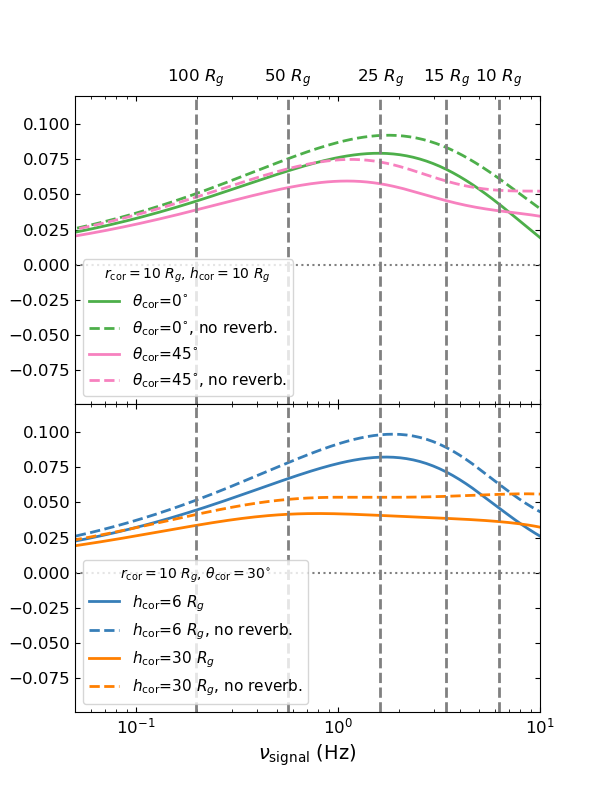

*******************************************************************
Calculating for geometrical parameters:  [4.0, 10.0, 4.0, 1000, 1000]
*******************************************************************
Coronal radius reset to nearest radial bin edge:  4.033506600176857
Maximum signal radius reset to:  296.265462867623
0.12083858741921656  of the disk flux is intercepted by the corona
0.284363355862671  of the coronal flux is intercepted by the disk
Seed energy : 1.0
Dissipation disk luminosity:  0.7851333433131683
Dissipation seed luminosity:  0.09487440414169006
Coronal heating luminosity:  0.2148666566868317
Disk luminosity due to heating by corona:  0.08807900750566212
Seed luminosity due to heating by corona:  0.008335949149572844
Mean gamma is: 2.0614626892106935
*******************************************************************
Calculating for geometrical parameters:  [4.0, 10.0, 4.0, 1000, 1000]
*******************************************************************
Coronal rad

/Users/philu/Dropbox/lag_models/mono_lags/um21_lagmodel.py:1341: RuntimeWarning: invalid value encountered in true_divide
  centroid = np.where(np.cumsum(irf) > 0, np.cumsum(irftau)/np.cumsum(irf),0.)
/Users/philu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in true_divide


0.4225989715695366  of the disk flux is intercepted by the corona
0.3333042531708212  of the coronal flux is intercepted by the disk
Seed energy : 1.0
Dissipation disk luminosity:  0.7851333433131683
Dissipation seed luminosity:  0.3317965434290968
Coronal heating luminosity:  0.2148666566868317
Disk luminosity due to heating by corona:  0.1822051696506107
Seed luminosity due to heating by corona:  0.05841902053798702
Mean gamma is: 2.5741364230679316
*******************************************************************
Calculating for geometrical parameters:  [4.0, 10.0, 13.999999999999998, 1000, 1000]
*******************************************************************
Coronal radius reset to nearest radial bin edge:  4.033506600176857
Maximum signal radius reset to:  296.265462867623
0.4225989715695366  of the disk flux is intercepted by the corona
0.0  of the coronal flux is intercepted by the disk
Seed energy : 1.0
Dissipation disk luminosity:  0.7851333433131683
Dissipation seed lum

/Users/philu/Dropbox/lag_models/mono_lags/um21_lagmodel.py:1341: RuntimeWarning: invalid value encountered in true_divide
  centroid = np.where(np.cumsum(irf) > 0, np.cumsum(irftau)/np.cumsum(irf),0.)
/Users/philu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in true_divide


0.23878124866557174  of the disk flux is intercepted by the corona
0.30482016134275813  of the coronal flux is intercepted by the disk
Seed energy : 1.0
Dissipation disk luminosity:  0.7851333433131683
Dissipation seed luminosity:  0.18747512008529338
Coronal heating luminosity:  0.2148666566868317
Disk luminosity due to heating by corona:  0.12264188531061113
Seed luminosity due to heating by corona:  0.030630593576623125
Mean gamma is: 2.3358292353682764
*******************************************************************
Calculating for geometrical parameters:  [4.0, 6.0, 7.4641016151377535, 1000, 1000]
*******************************************************************
Coronal radius reset to nearest radial bin edge:  4.033506600176857
Maximum signal radius reset to:  296.265462867623
0.23878124866557174  of the disk flux is intercepted by the corona
0.0  of the coronal flux is intercepted by the disk
Seed energy : 1.0
Dissipation disk luminosity:  0.7851333433131683
Dissipation see

/Users/philu/Dropbox/lag_models/mono_lags/um21_lagmodel.py:1341: RuntimeWarning: invalid value encountered in true_divide
  centroid = np.where(np.cumsum(irf) > 0, np.cumsum(irftau)/np.cumsum(irf),0.)
/Users/philu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in true_divide


0.37993497808509347  of the disk flux is intercepted by the corona
0.3286340539829572  of the coronal flux is intercepted by the disk
Seed energy : 1.0
Dissipation disk luminosity:  0.7851333433131683
Dissipation seed luminosity:  0.29829961958556483
Coronal heating luminosity:  0.2148666566868317
Disk luminosity due to heating by corona:  0.16864391373873586
Seed luminosity due to heating by corona:  0.027883874667167963
Mean gamma is: 2.498226693256904
*******************************************************************
Calculating for geometrical parameters:  [4.0, 30.0, 21.320508075688767, 1000, 1000]
*******************************************************************
Coronal radius reset to nearest radial bin edge:  4.033506600176857
Maximum signal radius reset to:  296.265462867623
0.37993497808509347  of the disk flux is intercepted by the corona
0.0  of the coronal flux is intercepted by the disk
Seed energy : 1.0
Dissipation disk luminosity:  0.7851333433131683
Dissipation seed

/Users/philu/Dropbox/lag_models/mono_lags/um21_lagmodel.py:1341: RuntimeWarning: invalid value encountered in true_divide
  centroid = np.where(np.cumsum(irf) > 0, np.cumsum(irftau)/np.cumsum(irf),0.)
/Users/philu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in true_divide


In [25]:
collist = [CBcol[2],CBcol[2],CBcol[3],CBcol[3],CBcol[0],CBcol[0],CBcol[1],CBcol[1]]
rcor = 4.0
hcorlist = [10.0,10.0,10.0,10.0,6.,6.,30.,30.] # Height of corona (for cylindrical or inverted cone coronal shapes)
angle_list = [0.,0.,45.,45.,30.,30.,30.,30.]  # Cone opening angle in degrees
disk_abs_list = [0.7,0.,0.7,0.,0.7,0.,0.7,0.] 
rtoplist = rcor + np.array(hcorlist)*np.tan(np.pi*(np.array(angle_list)/180))
geom_list = [] 
lstylist = ['solid','dashed','solid','dashed','solid','dashed','solid','dashed']

for i, hcorval in enumerate(hcorlist):
    geopar = [rcor,hcorval,rtoplist[i],1000,1000]
    if i < len(hcorlist)//2:
        if disk_abs_list[i] > 0:
            radtxt = r"$\theta_{\rm cor}$="+str(round(angle_list[i]))+"$^{\circ}$"
        else:
            radtxt = r"$\theta_{\rm cor}$="+str(round(angle_list[i]))+"$^{\circ}$, no reverb."
    else:
        if disk_abs_list[i] > 0:
            radtxt = r"$h_{\rm cor}$="+str(round(hcorval))+" $R_{g}$"
        else:
            radtxt = r"$h_{\rm cor}$="+str(round(hcorval))+" $R_{g}$, no reverb."
    geom_list.append([uml.inv_cone,geopar,disk_abs_list[i],collist[i],radtxt,lstylist[i]])

ens_mono = np.array([e_seed,3.0,9.0])
encomb = np.array([[2,0],[3,2]])

#figfile = 'figs/centroiddiffs_invcone_mono.pdf'
figfile = None
leg_title=[r'$r_{\rm cor}=10$ $R_{g}$, $h_{\rm cor}=10$ $R_{g}$',r'$r_{\rm cor}=10$ $R_{g}$, $\theta_{\rm cor}=30^{\circ}$']

sigrad = [100.0,50.0,25.0,15.0,10.0]
compare_disk_seed_centroids2(rin,rout,nrad,rsigmax,seedff_norm,seedff_ind,heatff_norm,heatff_ind,geom_list,
                    t_scale,disk_tau_par,cor_tau_par,lor_model,lor_par,
                    disk_prop_par,cor_prop_par,gamma_par,e_seed,ens_mono,encomb,nirf_mult,min_deltau_frac,
                    figfile,leg_title,sigrad)

In [16]:
def plot_flags_only(lags_list, vlines_list, axis_names, freqlim, tlaglim, leg_title=None, figfile=None):
    
    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,8),sharex=True)
    fig.subplots_adjust(hspace=0)
    for i, x in enumerate(lags_list):
        freq = x[0]
        tlag = x[1]
        colour_val = x[2]
        ls_val = x[3]
        label_val = x[4]
        if i < len(lags_list)//2:
            ax1.plot(freq,freq*tlag,color=colour_val,linewidth=3,linestyle=ls_val,label=label_val)
        else:
            ax2.plot(freq,freq*tlag,color=colour_val,linewidth=3,linestyle=ls_val,label=label_val)
    if (vlines_list != None):
        for line in vlines_list:
            for ax in (ax1, ax2):
                ax.axvline(line[0],color=line[1],alpha=0.5,linewidth=3,linestyle=line[2])
    ax2.set_xticklabels(ax2.get_xticks(), backgroundcolor='w')
    ax2.legend(fontsize=12,title=leg_title,title_fontsize=12)
    ax2.set_xlabel(axis_names[0],fontsize=14)
    ax1.set_ylabel(axis_names[1],fontsize=14)
    ax2.set_ylabel(axis_names[1],fontsize=14)
    ax2.set_xscale('log')
    ax2.set_xlim(freqlim)
    ax1.set_ylim(tlaglim)
    ax2.set_ylim(tlaglim)
    for i, ax in enumerate((ax1, ax2)):
        ax.tick_params(axis='x',labelsize=12, which='both', direction='in', top=True)
        ax.tick_params(axis='y',labelsize=12, which='both', direction='in', right=True)
        ax.tick_params(which='major', length=10)
        ax.tick_params(which='minor', length=6)
        ax.axhline(color='grey',linestyle='dotted')
        if leg_title != None:
            ax.legend(fontsize=11,title=leg_title[i])  
    if (figfile != None):
        plt.savefig(figfile,bbox_inches='tight')
    plt.show()

    return

In [19]:
ens_mono = np.array([e_seed,3.0,9.0])
encomb = np.array([[2,0],[3,2]])

cor_geometry = uml.inv_cone
rcor = 10.0
collist = [CBcol[2],CBcol[2],CBcol[3],CBcol[3],CBcol[0],CBcol[0],CBcol[1],CBcol[1]]
hcorlist = [10.0,10.0,10.0,10.0,6.,6.,30.,30.] # Height of corona (for cylindrical or inverted cone coronal shapes)
angle_list = [0.,0.,45.,45.,30.,30.,30.,30.]  # Cone opening angle in degrees
disk_abs_list = [0.7,0.,0.7,0.,0.7,0.,0.7,0.] 
rtoplist = rcor + np.array(hcorlist)*np.tan(np.pi*(np.array(angle_list)/180))
ls_list = ['solid','dashed','solid','dashed','solid','dashed','solid','dashed']

vlines_list = []
laglist = []
for i, hcorval in enumerate(hcorlist):
    geopar = [rcor,hcorval,rtoplist[i],1000,1000]
    gamma_mean, freq, phlag, tlag, psd_ci, psd_ref, tau, i_rcor, i_rsigmax, deltau, ldisk_disp, lseed_disp,\
        lheat, ldisk_rev, lseed_rev, flux_irf_mono, mod_sig_psd = \
    uml.run_stprod_mono(rin,rout,nrad,rcor,rsigmax,seedff_norm,seedff_ind,heatff_norm,heatff_ind,cor_geometry,
                    geopar,disk_abs_list[i],t_scale,disk_tau_par,cor_tau_par,lor_model,lor_par,
                    disk_prop_par,cor_prop_par,gamma_par,e_seed,ens_mono,encomb,nirf_mult,min_deltau_frac)
    if i < len(hcorlist)//2:
        if disk_abs_list[i] > 0:
            radtxt = r"$\theta_{\rm cor}$="+str(round(angle_list[i]))+"$^{\circ}$"
        else:
            radtxt = r"$\theta_{\rm cor}$="+str(round(angle_list[i]))+"$^{\circ}$, no reverb."
    else:
        if disk_abs_list[i] > 0:
            radtxt = r"$h_{\rm cor}$="+str(round(hcorval))+" $R_{g}$"
        else:
            radtxt = r"$h_{\rm cor}$="+str(round(hcorval))+" $R_{g}$, no reverb."

    laglist.append([np.copy(freq),np.copy(tlag[0,:]),collist[i],ls_list[i],radtxt])
        
vlines_list.append([1./(tau[i_rcor]*t_scale),'gray','dashdot'])


Coronal radius reset to nearest radial bin edge:  9.939835534143139
Maximum signal radius reset to:  296.265462867623
0.11739804475974155  of the disk flux is intercepted by the corona
0.22950349742824247  of the coronal flux is intercepted by the disk
Seed energy : 1.0
Dissipation disk luminosity:  0.41197833971469366
Dissipation seed luminosity:  0.048365451565869605
Coronal heating luminosity:  0.5880216602853063
Disk luminosity due to heating by corona:  0.14605306788810302
Seed luminosity due to heating by corona:  0.02002610601311896
Mean gamma is: 1.6267194243502572
#######################################
Calculating mono-energetic spectral-timing products
Time bin size dt is:  0.0010000306442932059
The maximum propagation delay is:  17.215485885700527  and there are  262144  irf bins.
CI mean, ref mean, CI outer, ref outer :  1.0 0.5580306954980037 0.0 0.0
Calculated for energies  [2 0]
CI mean, ref mean, CI outer, ref outer :  1.0 1.0 0.0 0.0
Calculated for energies  [3 2]
###

<IPython.core.display.Javascript object>


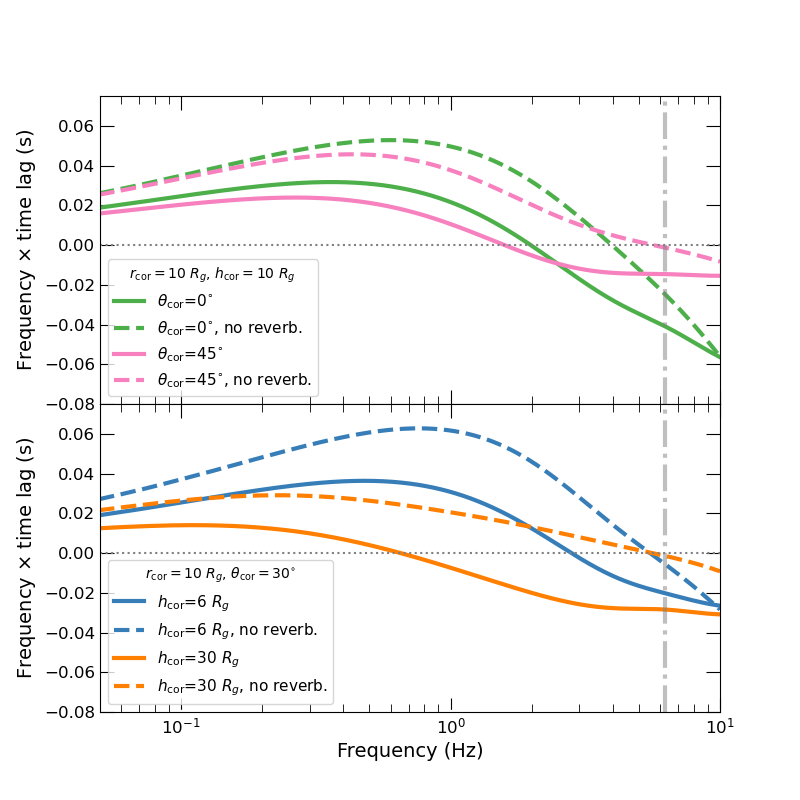

In [22]:
freqlim = [0.05,10.0]
tlaglim = [-0.08,0.075]
figfile = 'figs/flags_invcone_mono_hcorthetacorcompare.pdf'
#figfile = None
leg_title=[r'$r_{\rm cor}=10$ $R_{g}$, $h_{\rm cor}=10$ $R_{g}$',r'$r_{\rm cor}=10$ $R_{g}$, $\theta_{\rm cor}=30^{\circ}$']
axis_names = [r'Frequency (Hz)',r'Frequency $\times$ time lag (s)']

plot_flags_only(laglist, vlines_list, axis_names, freqlim, tlaglim, leg_title, figfile) 

In [ ]:
#First set up radial grid
rad_edge = np.logspace(np.log10(rin), np.log10(rout), nrad+1)  # set up radial bin edges
rad = np.sqrt(rad_edge[1:]*rad_edge[:-1])  # Define radial bin centres as geometric mean of bin edges
rad_area = np.pi*(np.square(rad_edge[1:])-np.square(rad_edge[:-1]))
disp_frac, seed_frac_flow, heat_frac_flow = \
    uml.calc_dispfrac(rad_edge,seedff_norm,seedff_ind,heatff_norm,heatff_ind) 

# Now reset coronal outer radius (i.e. disk inner radius) to be at the nearest radial bin edges
rcor, i_rcor = uml.find_nearest(rad_edge,rcor)

# Reset maximum signal radius to nearest radial bin value
rsigmax, i_rsigmax = uml.find_nearest(rad,rsigmax)
print("Coronal radius reset to nearest radial bin edge: ",rcor)
print("Maximum signal radius reset to: ",rsigmax)

# Calculate illumination of corona by disk and vice-versa
omega_cor, disktocor_frac, cortodisk_frac = uml.calc_illumination_fracs(rad,rad_area,cor_geometry,geopar)

cortodisk_frac = disk_abs_frac*cortodisk_frac   # Account for disk albedo (1-disk_abs_frac)

print(np.sum(disp_frac*disktocor_frac)," of the disk flux is intercepted by the corona")
print(np.sum(cortodisk_frac)," of the coronal flux is intercepted by the disk")

# Now calculate radial dependence of timing parameters and calculate propagation delays
tau, lfreq, q, rms = uml.calc_timing_params(rad, i_rsigmax, rcor, i_rcor, t_scale, disk_tau_par, cor_tau_par,\
                                        lor_model, lor_par)

deltau = uml.calc_propagation_params(rad,rad_edge,rcor,i_rcor,disk_prop_par,cor_prop_par)

# Calculate the radially-dependent direct disk, seed photon and coronal heating luminosities
ldisk_disp, lseed_disp, lheat, ldisk_rev, lseed_rev =\
    uml.calc_radial_time_response(rad,i_rcor,disp_frac,disktocor_frac,cortodisk_frac,seed_frac_flow,heat_frac_flow)


print("Dissipation disk luminosity: ",np.sum(ldisk_disp))
print("Dissipation seed luminosity: ",np.sum(lseed_disp))
print("Coronal heating luminosity: ",np.sum(lheat))
print("Disk luminosity due to heating by corona: ",np.sum(ldisk_rev))
print("Seed luminosity due to heating by corona: ",np.sum(lseed_rev))

In [ ]:
# Calculate IRFs 
gamma_mean, gamma_irf, flux_irf, disk_irf, seed_irf =\
                    uml.calc_irfs_mono(gamma_par,e_seed,ens_mono,\
                                ldisk_disp,lseed_disp,lheat,ldisk_rev,lseed_rev)
print("Mean gamma is:", gamma_mean)

# Calculate frequency-dependent spectral-timing products using the mono-energetic calculation
freq, phlag, tlag, psd_ci, psd_ref, mod_sig_psd, irf_nbins, irf_binedgefrac, deltau_scale, dt, nirf,\
        ci_irf, ci_mean, ci_outer =\
        uml.calculate_stprod_mono(nirf_mult,ens_mono,encomb,flux_irf,disk_irf,gamma_irf,
                                deltau,min_deltau_frac,i_rsigmax,lfreq,q,rms,t_scale)


In [ ]:
#plot_disk_seed_centroids(disk_irf,seed_irf,flux_irf[2,:],deltau_scale,lfreq,rad,gamma_mean,gamma_par[1],
#                             ens_mono[1],e_seed)


def plot_disk_seed_centroids2(disk_irf,seed_irf,flux_irf,deltau_scale,lfreq,rad,sigrad,gamma_mean,gamma_ind,
                             en,e_seed,figfile):
    disk_cent = uml.calc_irf_centroid(disk_irf,deltau_scale)
    seed_cent = uml.calc_irf_centroid(seed_irf,deltau_scale)
    flux_cent = uml.calc_irf_centroid(flux_irf,deltau_scale)
    CBcol = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00'] # Colour palette better for range of colour-blindness
    plt.figure()
    plt.plot(lfreq,lfreq*disk_cent,linewidth=4,color=CBcol[0],label='Disk')
    plt.plot(lfreq,lfreq*seed_cent,linewidth=4,color=CBcol[1],label='Seed')
    u = gamma_mean*gamma_ind*(np.log(en/e_seed)-(gamma_mean-1)**(-1))
    lfrac = np.where(np.cumsum(seed_irf) > 0., 1./(np.cumsum(seed_irf)/np.sum(seed_irf)), 0.)
    print((1-u)/(1+u*(lfrac-1)),lfrac)
#    plt.plot(lfreq,lfreq*seed_cent*(1-u)/(1+u*(lfrac-1)),linewidth=4,color=CBcol[2],
#             label='Corrected seed',linestyle='dashed')
    plt.plot(lfreq,lfreq*flux_cent,linewidth=4,color=CBcol[3],linestyle='dashed',label='Flux at $E_{\rm soft}$')
    if sigrad != None:
        for radius in sigrad:
            rsig, i_rsig = uml.find_nearest(rad,radius)
            tausig = np.sum(deltau_scale[:i_rsig])
            plt.axvline(lfreq[i_rsig],color='gray',linestyle='dashed',linewidth=2)
            radtxt = str(round(radius))+" $R_{g}$"
            plt.text(lfreq[i_rsig],1.1,radtxt,fontsize=12,horizontalalignment='center')
    plt.xlabel(r'$\nu_{\rm signal}$',fontsize=14)
    plt.ylabel('-1 x IRF centroid delay (s)', fontsize=14)
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim(0.05,10.0)
    plt.ylim(0.001,1.0)
    plt.legend(fontsize=12)
    if figfile != None:
        plt.savefig(figfile,bbox_inches='tight')
    plt.show()
    plt.show()
    return

sigrad = [100.0,50.0,25.0,15.0,10.0]

#figfile = 'figs/irfs_invcone_mono_rcorcompare.pdf'
figfile = None

plot_disk_seed_centroids2((ldisk_disp+ldisk_rev),(lseed_disp+lseed_rev),flux_irf[1,:],deltau_scale,lfreq,rad,
                         sigrad,gamma_mean,gamma_par[1],ens_mono[1],e_seed,figfile)


In [ ]:
cor_geometry = uml.inv_cone

# Calculate illumination of corona by disk and vice-versa
rcor = 10.0 # Outer radius of corona and inner radius of blackbody emitting disk
# Now reset coronal outer radius (i.e. disk inner radius) to be at the nearest radial bin edges
rcor, i_rcor = uml.find_nearest(rad_edge,rcor)
hcor = 6.0 # Height of corona (for cylindrical or inverted cone coronal shapes)
cone_angle = 45.0  # Cone opening angle in degrees
rtop = rcor + hcor*np.tan(np.pi*(cone_angle/180))
print("Coronal top radius : ",rtop)
geopar = [rcor,hcor,rtop,1000,1000]
omega_cor, disktocor_frac, cortodisk_frac = uml.calc_illumination_fracs(rad,rad_area,cor_geometry,geopar)
cortodisk_frac = disk_abs_frac*cortodisk_frac   # Account for disk albedo (1-disk_abs_frac)
print(np.sum(disp_frac*disktocor_frac)," of the disk flux is intercepted by the corona")
print(np.sum(cortodisk_frac)," of the coronal flux is intercepted by the disk")
# Calculate the radially-dependent direct disk, seed photon and coronal heating luminosities
ldisk_disp1, lseed_disp1, lheat1, ldisk_rev1, lseed_rev1 =\
    uml.calc_radial_time_response(rad,i_rcor,disp_frac,disktocor_frac,cortodisk_frac,seed_frac_flow,heat_frac_flow)

# Calculate illumination of corona by disk and vice-versa
rcor = 10.0 # Outer radius of corona and inner radius of blackbody emitting disk
# Now reset coronal outer radius (i.e. disk inner radius) to be at the nearest radial bin edges
rcor, i_rcor = uml.find_nearest(rad_edge,rcor)
hcor = 20.0 # Height of corona (for cylindrical or inverted cone coronal shapes)
cone_angle = 45.0  # Cone opening angle in degrees
rtop = rcor + hcor*np.tan(np.pi*(cone_angle/180))
print("Coronal top radius : ",rtop)
geopar = [rcor,hcor,rtop,1000,1000]
omega_cor, disktocor_frac, cortodisk_frac = uml.calc_illumination_fracs(rad,rad_area,cor_geometry,geopar)
cortodisk_frac = disk_abs_frac*cortodisk_frac   # Account for disk albedo (1-disk_abs_frac)
print(np.sum(disp_frac*disktocor_frac)," of the disk flux is intercepted by the corona")
print(np.sum(cortodisk_frac)," of the coronal flux is intercepted by the disk")
# Calculate the radially-dependent direct disk, seed photon and coronal heating luminosities
ldisk_disp2, lseed_disp2, lheat2, ldisk_rev2, lseed_rev2 =\
    uml.calc_radial_time_response(rad,i_rcor,disp_frac,disktocor_frac,cortodisk_frac,seed_frac_flow,heat_frac_flow)

# Calculate illumination of corona by disk and vice-versa
rcor = 10.0 # Outer radius of corona and inner radius of blackbody emitting disk
# Now reset coronal outer radius (i.e. disk inner radius) to be at the nearest radial bin edges
rcor, i_rcor = uml.find_nearest(rad_edge,rcor)
hcor = 40.0 # Height of corona (for cylindrical or inverted cone coronal shapes)
cone_angle = 45.0  # Cone opening angle in degrees
rtop = rcor + hcor*np.tan(np.pi*(cone_angle/180))
print("Coronal top radius : ",rtop)
geopar = [rcor,hcor,rtop,1000,1000]
omega_cor, disktocor_frac, cortodisk_frac = uml.calc_illumination_fracs(rad,rad_area,cor_geometry,geopar)
cortodisk_frac = disk_abs_frac*cortodisk_frac   # Account for disk albedo (1-disk_abs_frac)
print(np.sum(disp_frac*disktocor_frac)," of the disk flux is intercepted by the corona")
print(np.sum(cortodisk_frac)," of the coronal flux is intercepted by the disk")
# Calculate the radially-dependent direct disk, seed photon and coronal heating luminosities
ldisk_disp3, lseed_disp3, lheat3, ldisk_rev3, lseed_rev3 =\
    uml.calc_radial_time_response(rad,i_rcor,disp_frac,disktocor_frac,cortodisk_frac,seed_frac_flow,heat_frac_flow)

ldisk_list = [ldisk_disp1+ldisk_rev1,ldisk_disp2+ldisk_rev2,ldisk_disp3+ldisk_rev3]
lseed_list = [lseed_disp1+lseed_rev1,lseed_disp2+lseed_rev2,lseed_disp3+lseed_rev3]
lheat_list = [lheat1,lheat2,lheat3]

In [ ]:
def plot_irfs_list(disk_irfs,seed_irfs,heat_irfs,lstyles,deltau,minbin,i_rcor,i_rsigmax,sigrad,rad):
    CBcol = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00'] # Colour palette better for range of colour-blindness
    plt.figure()
    for i, disk_irf in enumerate(disk_irfs):
        seed_irf = seed_irfs[i]
        heat_irf = heat_irfs[i]
        tau_edges, disk_irf_rb = irf_plot_rebin(disk_irf,deltau,minbin,i_rcor,i_rsigmax)
        tau_edges, seed_irf_rb = irf_plot_rebin(seed_irf,deltau,minbin,i_rcor,i_rsigmax)
        tau_edges, heat_irf_rb = irf_plot_rebin(heat_irf,deltau,minbin,i_rcor,i_rsigmax)
        dummy_data = (tau_edges[1:] + tau_edges[:-1])/2.
        dtau = -0.5*(tau_edges[:-1]+tau_edges[1:])
        dtau[-1] = 1
        print(heat_irf_rb,dtau)
        disk_bins, edges, patches = plt.hist(dummy_data, bins=tau_edges, weights=np.abs(dtau)*disk_irf_rb, 
                    histtype='step',linestyle=lstyles[i],linewidth=2,color=CBcol[0],label='Disk')
        seed_bins, edges, patches = plt.hist(dummy_data, bins=tau_edges, weights=np.abs(dtau)*seed_irf_rb,
                    histtype='step',linestyle=lstyles[i],linewidth=2,color=CBcol[1],label='Seed')
        heat_bins, edges, patches = plt.hist(dummy_data, bins=tau_edges, weights=np.abs(dtau)*heat_irf_rb,
                    histtype='step',linestyle=lstyles[i],linewidth=2,color=CBcol[2],label='Coronal heating')
        plt.scatter(np.mean(tau_edges[-2:]),disk_irf_rb[-1],marker='_',s=500,
                linewidth=2,linestyle=lstyles[i],color=CBcol[0])
        plt.scatter(np.mean(tau_edges[-2:]),seed_irf_rb[-1],marker='_',s=500,
                linewidth=2,linestyle=lstyles[i],color=CBcol[1])
        plt.scatter(np.mean(tau_edges[-2:]),heat_irf_rb[-1],marker='_',s=500,
                linewidth=2,linestyle=lstyles[i],color=CBcol[2])
    plt.yscale('log')
    plt.xscale('symlog', linthreshx=1e3, linscalex=0.5)
    plt.xlim(-1.*np.sum(deltau[i_rcor:i_rsigmax+1]),np.sum(deltau[:i_rcor])+1000.)
    plt.ylim(4e-5,1)
    plt.xticks([-1e5,-1e4,-1e3,0],fontsize=11) 
    plt.yticks(fontsize=12)
    plt.xlabel('Delay ($R_g/c$)', fontsize=13)
    plt.ylabel(r'Response [fraction of $L_{\rm tot}$] ($c/R_g$)', fontsize=13)
    for radius in sigrad:
        rsig, i_rsig = uml.find_nearest(rad,radius)
        tausig = np.sum(deltau[:i_rsig+1])
        plt.axvline(-1.*tausig,color='gray',linestyle='dotted',linewidth=2)
        radtxt = str(round(radius))+" $R_{g}$"
        plt.text(-1.*tausig,3.0,radtxt,fontsize=12,horizontalalignment='center')
#    plt.legend(fontsize=12)
#    plt.savefig('figs/irf_5radii_spherical_monoseed_10rg.pdf',bbox_inches='tight')
    plt.show()    
    return

lstyles = ['solid','dotted','dashed']
#plot_irfs_list(ldisk_list,lseed_list,lheat_list,lstyles,deltau,1.0,i_rcor,i_rsigmax,sigrad,rad)


In [ ]:
cor_geometry = uml.inv_cone

# Calculate illumination of corona by disk and vice-versa
rcor = 10.0 # Outer radius of corona and inner radius of blackbody emitting disk
# Now reset coronal outer radius (i.e. disk inner radius) to be at the nearest radial bin edges
rcor, i_rcor = uml.find_nearest(rad_edge,rcor)
hcor = 20.0 # Height of corona (for cylindrical or inverted cone coronal shapes)
cone_angle = 0.0  # Cone opening angle in degrees
rtop = rcor + hcor*np.tan(np.pi*(cone_angle/180))
print("Coronal top radius : ",rtop)
geopar = [rcor,hcor,rtop,1000,1000]
omega_cor, disktocor_frac, cortodisk_frac = uml.calc_illumination_fracs(rad,rad_area,cor_geometry,geopar)
cortodisk_frac = disk_abs_frac*cortodisk_frac   # Account for disk albedo (1-disk_abs_frac)
print(np.sum(disp_frac*disktocor_frac)," of the disk flux is intercepted by the corona")
print(np.sum(cortodisk_frac)," of the coronal flux is intercepted by the disk")
# Calculate the radially-dependent direct disk, seed photon and coronal heating luminosities
ldisk_disp1, lseed_disp1, lheat1, ldisk_rev1, lseed_rev1 =\
    uml.calc_radial_time_response(rad,i_rcor,disp_frac,disktocor_frac,cortodisk_frac,seed_frac_flow,heat_frac_flow)

# Calculate illumination of corona by disk and vice-versa
rcor = 10.0 # Outer radius of corona and inner radius of blackbody emitting disk
# Now reset coronal outer radius (i.e. disk inner radius) to be at the nearest radial bin edges
rcor, i_rcor = uml.find_nearest(rad_edge,rcor)
hcor = 20.0 # Height of corona (for cylindrical or inverted cone coronal shapes)
cone_angle = 20.0  # Cone opening angle in degrees
rtop = rcor + hcor*np.tan(np.pi*(cone_angle/180))
print("Coronal top radius : ",rtop)
geopar = [rcor,hcor,rtop,1000,1000]
omega_cor, disktocor_frac, cortodisk_frac = uml.calc_illumination_fracs(rad,rad_area,cor_geometry,geopar)
cortodisk_frac = disk_abs_frac*cortodisk_frac   # Account for disk albedo (1-disk_abs_frac)
print(np.sum(disp_frac*disktocor_frac)," of the disk flux is intercepted by the corona")
print(np.sum(cortodisk_frac)," of the coronal flux is intercepted by the disk")
# Calculate the radially-dependent direct disk, seed photon and coronal heating luminosities
ldisk_disp2, lseed_disp2, lheat2, ldisk_rev2, lseed_rev2 =\
    uml.calc_radial_time_response(rad,i_rcor,disp_frac,disktocor_frac,cortodisk_frac,seed_frac_flow,heat_frac_flow)

# Calculate illumination of corona by disk and vice-versa
rcor = 10.0 # Outer radius of corona and inner radius of blackbody emitting disk
# Now reset coronal outer radius (i.e. disk inner radius) to be at the nearest radial bin edges
rcor, i_rcor = uml.find_nearest(rad_edge,rcor)
hcor = 20.0 # Height of corona (for cylindrical or inverted cone coronal shapes)
cone_angle = 45.0  # Cone opening angle in degrees
rtop = rcor + hcor*np.tan(np.pi*(cone_angle/180))
print("Coronal top radius : ",rtop)
geopar = [rcor,hcor,rtop,1000,1000]
omega_cor, disktocor_frac, cortodisk_frac = uml.calc_illumination_fracs(rad,rad_area,cor_geometry,geopar)
cortodisk_frac = disk_abs_frac*cortodisk_frac   # Account for disk albedo (1-disk_abs_frac)
print(np.sum(disp_frac*disktocor_frac)," of the disk flux is intercepted by the corona")
print(np.sum(cortodisk_frac)," of the coronal flux is intercepted by the disk")
# Calculate the radially-dependent direct disk, seed photon and coronal heating luminosities
ldisk_disp3, lseed_disp3, lheat3, ldisk_rev3, lseed_rev3 =\
    uml.calc_radial_time_response(rad,i_rcor,disp_frac,disktocor_frac,cortodisk_frac,seed_frac_flow,heat_frac_flow)

ldisk_list = [ldisk_disp1+ldisk_rev1,ldisk_disp2+ldisk_rev2,ldisk_disp3+ldisk_rev3]
lseed_list = [lseed_disp1+lseed_rev1,lseed_disp2+lseed_rev2,lseed_disp3+lseed_rev3]
lheat_list = [lheat1,lheat2,lheat3]

plot_irfs_list(ldisk_list,lseed_list,lheat_list,lstyles,deltau,1.0,i_rcor,i_rsigmax,sigrad,rad)

In [ ]:
cor_geometry = uml.an_sphere

# Calculate illumination of corona by disk and vice-versa
rcor = 6.0 # Outer radius of corona and inner radius of blackbody emitting disk
# Now reset coronal outer radius (i.e. disk inner radius) to be at the nearest radial bin edges
rcor, i_rcor = uml.find_nearest(rad_edge,rcor)
print("radius",rcor)
hcor = 20.0 # Height of corona (for cylindrical or inverted cone coronal shapes)
cone_angle = 0.0  # Cone opening angle in degrees
rtop = rcor + hcor*np.tan(np.pi*(cone_angle/180))
print("Coronal top radius : ",rtop)
geopar = [rcor]
omega_cor, disktocor_frac, cortodisk_frac = uml.calc_illumination_fracs(rad,rad_area,cor_geometry,geopar)
cortodisk_frac = disk_abs_frac*cortodisk_frac   # Account for disk albedo (1-disk_abs_frac)
print(np.sum(disp_frac*disktocor_frac)," of the disk flux is intercepted by the corona")
print(np.sum(cortodisk_frac)," of the coronal flux is intercepted by the disk")
# Calculate the radially-dependent direct disk, seed photon and coronal heating luminosities
ldisk_disp1, lseed_disp1, lheat1, ldisk_rev1, lseed_rev1 =\
    uml.calc_radial_time_response(rad,i_rcor,disp_frac,disktocor_frac,cortodisk_frac,seed_frac_flow,heat_frac_flow)

# Calculate illumination of corona by disk and vice-versa
rcor = 10.0 # Outer radius of corona and inner radius of blackbody emitting disk
# Now reset coronal outer radius (i.e. disk inner radius) to be at the nearest radial bin edges
rcor, i_rcor = uml.find_nearest(rad_edge,rcor)
print("radius",rcor)
hcor = 20.0 # Height of corona (for cylindrical or inverted cone coronal shapes)
cone_angle = 20.0  # Cone opening angle in degrees
rtop = rcor + hcor*np.tan(np.pi*(cone_angle/180))
print("Coronal top radius : ",rtop)
geopar = [rcor]
omega_cor, disktocor_frac, cortodisk_frac = uml.calc_illumination_fracs(rad,rad_area,cor_geometry,geopar)
cortodisk_frac = disk_abs_frac*cortodisk_frac   # Account for disk albedo (1-disk_abs_frac)
print(np.sum(disp_frac*disktocor_frac)," of the disk flux is intercepted by the corona")
print(np.sum(cortodisk_frac)," of the coronal flux is intercepted by the disk")
# Calculate the radially-dependent direct disk, seed photon and coronal heating luminosities
ldisk_disp2, lseed_disp2, lheat2, ldisk_rev2, lseed_rev2 =\
    uml.calc_radial_time_response(rad,i_rcor,disp_frac,disktocor_frac,cortodisk_frac,seed_frac_flow,heat_frac_flow)

# Calculate illumination of corona by disk and vice-versa
rcor = 20.0 # Outer radius of corona and inner radius of blackbody emitting disk
# Now reset coronal outer radius (i.e. disk inner radius) to be at the nearest radial bin edges
rcor, i_rcor = uml.find_nearest(rad_edge,rcor)
print("radius",rcor)
hcor = 20.0 # Height of corona (for cylindrical or inverted cone coronal shapes)
cone_angle = 45.0  # Cone opening angle in degrees
rtop = rcor + hcor*np.tan(np.pi*(cone_angle/180))
print("Coronal top radius : ",rtop)
geopar = [rcor]
omega_cor, disktocor_frac, cortodisk_frac = uml.calc_illumination_fracs(rad,rad_area,cor_geometry,geopar)
cortodisk_frac = disk_abs_frac*cortodisk_frac   # Account for disk albedo (1-disk_abs_frac)
print(np.sum(disp_frac*disktocor_frac)," of the disk flux is intercepted by the corona")
print(np.sum(cortodisk_frac)," of the coronal flux is intercepted by the disk")
# Calculate the radially-dependent direct disk, seed photon and coronal heating luminosities
ldisk_disp3, lseed_disp3, lheat3, ldisk_rev3, lseed_rev3 =\
    uml.calc_radial_time_response(rad,i_rcor,disp_frac,disktocor_frac,cortodisk_frac,seed_frac_flow,heat_frac_flow)

ldisk_list = [ldisk_disp1+ldisk_rev1,ldisk_disp2+ldisk_rev2,2*(ldisk_disp3+ldisk_rev3)]
lseed_list = [lseed_disp1+lseed_rev1,lseed_disp2+lseed_rev2,lseed_disp3+lseed_rev3]
lheat_list = [lheat1,lheat2,lheat3]
sigrad = [100.0,50.0,25.0,15.0,12.0,10.0]
plot_irfs_list(ldisk_list,lseed_list,lheat_list,lstyles,deltau,1.0,i_rcor,i_rsigmax,sigrad,rad)

In [ ]:
# Plot frequency-dependent spectral-timing products
%matplotlib notebook
plt.figure()
plt.plot(freq,phlag[0,:],color="red",linestyle="dashed")
plt.plot(freq,phlag[1,:],color="green",linestyle="dashed")
plt.plot(freq,phlag[2,:],color="blue",linestyle="dashed")
plt.xlabel('Frequency (Hz)')
plt.ylabel('Phase lag (radians)')
plt.yscale('linear')
plt.xscale('log')
plt.show()

plt.figure()
plt.plot(freq,tlag[0,:],color="red",linestyle="dashed")
plt.plot(freq,tlag[1,:],color="green",linestyle="dashed")
plt.plot(freq,tlag[2,:],color="blue",linestyle="dashed")
plt.xlabel('Frequency (Hz)')
plt.ylabel('Time lag (s)')
plt.yscale('symlog')
plt.xscale('log')
plt.yticks(np.linspace(0.,0.1,6))
plt.ylim([-0.03,0.01])
plt.show()

plt.figure()
plt.plot(freq,freq*psd_ref[0,:],color="red",linestyle="dashed")
plt.plot(freq,freq*psd_ci[0,:],color="black",linestyle="dashed")
plt.plot(freq,freq*psd_ci[1,:],color="green",linestyle="dashed")
plt.plot(freq,freq*psd_ci[2,:],color="blue",linestyle="dashed")
plt.xlabel('Frequency (Hz)')
plt.ylabel('Frequency x Power (fractional rms$^{2}$)')
plt.yscale('log')
plt.xscale('log')
plt.show()

In [ ]:
# Plot energy-dependent spectral-timing products

plt.figure()
plt.plot(ens,phlagen[:,0],color="black")
plt.plot(ens,phlagen[:,1],color="red")
plt.plot(ens,phlagen[:,2],color="green")
plt.xlim([0.1,20.0])
plt.yscale('linear')
plt.xscale('log')
plt.xlabel('Energy (keV)')
plt.ylabel('Relative phase lag (radians)')
plt.show()

plt.figure()
plt.plot(ens,tlagen[:,0],color="black")
plt.plot(ens,tlagen[:,1],color="red")
plt.plot(ens,tlagen[:,2],color="green")
plt.xlim([0.1,20.0])
plt.yscale('linear')
plt.xscale('log')
plt.xlabel('Energy (keV)')
plt.ylabel('Relative time lag (s)')
plt.show()

plt.figure()
plt.plot(ens,rmsen[:,0],color="black")
plt.plot(ens,rmsen[:,1],color="red")
plt.plot(ens,rmsen[:,2],color="green")
plt.xlim([0.1,20.0])
plt.yscale('linear')
plt.xscale('log')
plt.xlabel('Energy (keV)')
plt.ylabel('Fractional rms')
plt.show()